# 0408 Xgboost Prediction with K-means and DBSCAN

> **ADJUSTABLE PARAMETER**
- FRACTION_SELECTED

> **FUNCTIONS**
- def `split_data`(clustered_name, targer_feature, test_size, random_state)
- def `hyperparameter_tuning`(cv, n_jobs, X_train, y_train)
- def `train_model`(max_depth, learning_rate, n_estimators, X_train, y_train, X_test, y_test)

### Import packages

In [23]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

### Import the data

In [2]:
dbscan_data = pd.read_csv('Xinyi_clustering_DBSCAN.csv')
kmeans_data = pd.read_csv('Xinyi_clustering_K-means.csv')
hierarchical_data = pd.read_csv('Xinyi_clustering_hierarchical.csv')

### Set the fraction percentage and select the used data

In [3]:
FRACTION_SELECTED = 0.2

In [4]:
# Randonly select 10% of the data for each clustering method
dbscan = dbscan_data.sample(frac=FRACTION_SELECTED)
kmeans = kmeans_data.sample(frac=FRACTION_SELECTED)
hierarchical = hierarchical_data.sample(frac=FRACTION_SELECTED)

### Split the data into training and testing sets

In [5]:
# Function to split the data into training and testing sets
def split_data(clustered_name, targer_feature, test_size, random_state):
    X = clustered_name.drop([targer_feature], axis=1)
    y = clustered_name[targer_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [6]:
# DBSCAN
X_train_dbscan, X_test_dbscan, y_train_dbscan, y_test_dbscan = split_data(dbscan, '總價元', 0.2, 42)

# K-means
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = split_data(kmeans, '總價元', 0.2, 42)

# Hierarchical
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical = split_data(hierarchical, '總價元', 0.2, 42)

### Hyperparameter Tuning for XGBoost

In [7]:
# Function for hyperparameter tuning
def hyperparameter_tuning(cv, n_jobs, X_train, y_train):
    model_dbscan = xgb.XGBRegressor()
    param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300]
    }
    grid_search = GridSearchCV(model_dbscan, param_grid, cv=cv, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [8]:
# DBSCAN
best_params_dbscan = hyperparameter_tuning(5, -1, X_train_dbscan, y_train_dbscan)

# K-means
best_params_kmeans = hyperparameter_tuning(5, -1, X_train_kmeans, y_train_kmeans)

# Hierarchical
best_params_hierarchical = hyperparameter_tuning(5, -1, X_train_hierarchical, y_train_hierarchical)

In [11]:
print('DBSCAN:', best_params_dbscan)
print('K-means:', best_params_kmeans)
print('Hierarchical:', best_params_hierarchical)

DBSCAN: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
K-means: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Hierarchical: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


### Train the model

In [9]:
# Function to train the model
def train_model(max_depth, learning_rate, n_estimators, X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    return mse, r2, accuracy, model

In [12]:
# DBSCAN
mse_dbscan, r2_dbscan, accuracy_dbscan, model_dbscan = train_model(best_params_dbscan['max_depth'], best_params_dbscan['learning_rate'], best_params_dbscan['n_estimators'], X_train_dbscan, y_train_dbscan, X_test_dbscan, y_test_dbscan)
print('DBSCAN')
print('MSE:', mse_dbscan)
print('R2:', r2_dbscan)
print('Accuracy:', accuracy_dbscan)
print("="*20)

# K-means
mse_kmeans, r2_kmeans, accuracy_kmeans, model_kmeans = train_model(best_params_kmeans['max_depth'], best_params_kmeans['learning_rate'], best_params_kmeans['n_estimators'], X_train_kmeans, y_train_kmeans, X_test_kmeans, y_test_kmeans)
print('K-means')
print('MSE:', mse_kmeans)
print('R2:', r2_kmeans)
print('Accuracy:', accuracy_kmeans)
print("="*20)

# Hierarchical
mse_hierarchical, r2_hierarchical, accuracy_hierarchical, model_hierarchical = train_model(best_params_hierarchical['max_depth'], best_params_hierarchical['learning_rate'], best_params_hierarchical['n_estimators'], X_train_hierarchical, y_train_hierarchical, X_test_hierarchical, y_test_hierarchical)
print('Hierarchical')
print('MSE:', mse_hierarchical)
print('R2:', r2_hierarchical)
print('Accuracy:', accuracy_hierarchical)

DBSCAN
MSE: 124919010734580.08
R2: 0.8976079079959004
Accuracy: 0.8976079079959004
K-means
MSE: 253419764961108.3
R2: 0.8456907933271055
Accuracy: 0.8456907933271055
Hierarchical
MSE: 319395550222064.5
R2: 0.8206911754618129
Accuracy: 0.8206911754618129


### Feature Importance

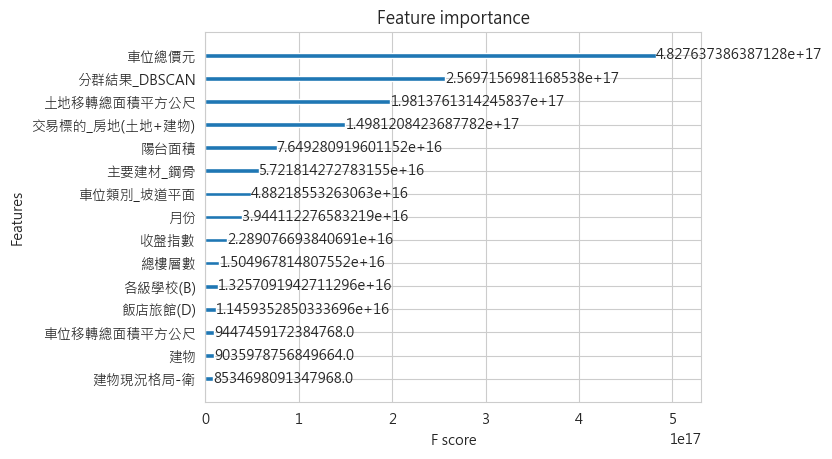

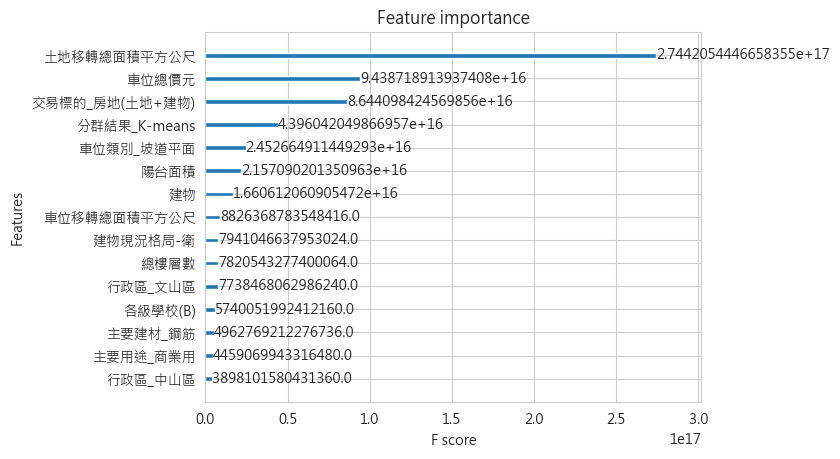

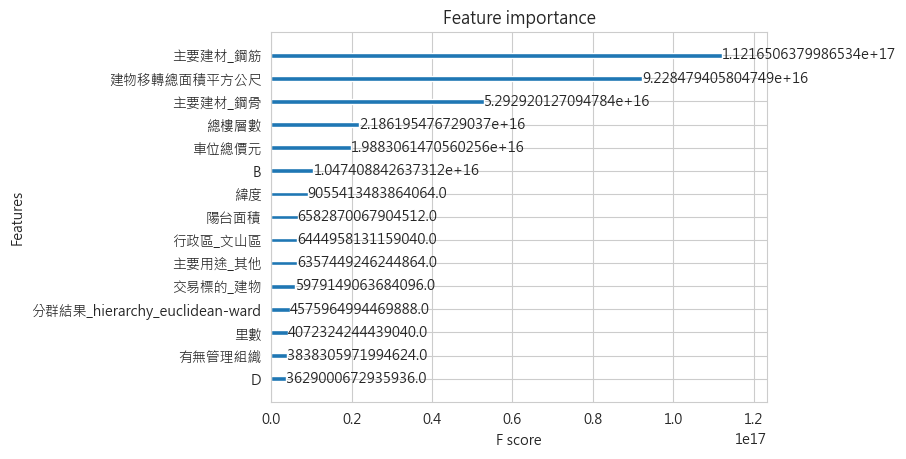

In [24]:
# DBSCAN
plot_importance(model_dbscan, max_num_features=15, importance_type='gain')
plt.show()

# K-means
plot_importance(model_kmeans, max_num_features=15, importance_type='gain')
plt.show()

# Hierarchical
plot_importance(model_hierarchical, max_num_features=15, importance_type='gain')
plt.show()